Please draw two rectangles on the first image to select the ROIs.
ROI selected: (618, 762, 784, 940)
ROI selected: (262, 448, 1528, 1712)


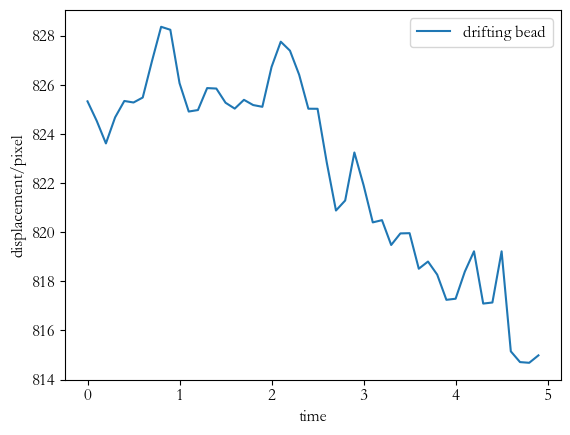

In [17]:
import numpy as np
from scipy.ndimage import center_of_mass
from PIL import Image
import cv2
import glob
import os
import matplotlib.pyplot as plt

# 调节阈值
threshold_constant = 0.7

# 时间间隔
time_interval = 0.1

# 文件夹路径
image_folder = "C:\\Users\\PC\\Desktop\\final year project\\pictures\\20250119"

# 存储所有图片的距离
output_distances = []  

# 加载文件夹中的所有图片（假设文件夹中只有图片文件）
image_files = glob.glob(os.path.join(image_folder, "*.png"))
image_files = image_files[:50]

# 检查是否有图片
if not image_files:
    raise ValueError("No images found in the folder.")

# 存储选中的点坐标
rois = []

# 缩放比例
scale = 0.5  # 图像缩小到 50%

# OpenCV 鼠标回调函数
def select_rois(event, x, y, flags, param):
    """
    OpenCV 鼠标回调函数，用于选择矩形区域的坐标。
    """
    global rois, drawing, ix, iy

    if event == cv2.EVENT_LBUTTONDOWN:  # 鼠标左键按下
        drawing = True
        ix, iy = x, y  # 记录起始点

    elif event == cv2.EVENT_LBUTTONUP:  # 鼠标左键释放
        drawing = False
        # 将坐标转换为原始图像的坐标
        x_original = int(x / scale)
        y_original = int(y / scale)
        ix_original = int(ix / scale)
        iy_original = int(iy / scale)
        # 记录 ROI 的坐标 (y_min, y_max, x_min, x_max)
        rois.append((min(iy_original, y_original), max(iy_original, y_original), 
                     min(ix_original, x_original), max(ix_original, x_original)))
        print(f"ROI selected: {rois[-1]}")
        # 在原始图像上绘制矩形
        cv2.rectangle(original_image, (ix_original, iy_original), (x_original, y_original), (0, 255, 0), 2)
        # 更新显示图像
        resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)
        cv2.imshow("Select ROIs", resized_image)

# Step 1: 在第一张图片上选择 ROI
print("Please draw two rectangles on the first image to select the ROIs.")
first_image_path = image_files[0]
first_image = Image.open(first_image_path).convert("L")  # 转换为灰度图像
first_image_array = np.array(first_image)

# 将图像转换为 OpenCV 格式（BGR）
original_image = cv2.cvtColor(first_image_array, cv2.COLOR_GRAY2BGR)

# 调整图像大小
resized_image = cv2.resize(original_image, (0, 0), fx=scale, fy=scale)

# 创建窗口并绑定鼠标回调函数
cv2.namedWindow("Select ROIs", cv2.WINDOW_NORMAL)
cv2.setMouseCallback("Select ROIs", select_rois)

# 显示图像并等待用户选择 ROI
while True:
    cv2.imshow("Select ROIs", resized_image)
    key = cv2.waitKey(1) & 0xFF
    if len(rois) >= 2:  # 选择两个 ROI 后退出
        break
    if key == 27:  # 按下 ESC 键退出
        break

cv2.destroyAllWindows()

# 检查是否选择了两个 ROI
if len(rois) < 2:
    raise ValueError("Please select exactly two ROIs.")

# 提取两个 ROI 的坐标
roi1 = rois[0]
roi2 = rois[1]

# Step 2: 对文件夹中的所有图片进行处理
for one_image_path in image_files:
    # 加载图片并转换为灰度图像
    image = Image.open(one_image_path).convert("L")
    image_array = np.array(image)

    # 提取两个 ROI
    roi1_array = image_array[roi1[0]:roi1[1], roi1[2]:roi1[3]]
    roi2_array = image_array[roi2[0]:roi2[1], roi2[2]:roi2[3]]
    # Step 3: 对 ROI 进行二值化处理
    threshold1 = np.mean(roi1_array) + threshold_constant*np.std(roi1_array)  # 自适应阈值
    threshold2 = np.mean(roi2_array) + threshold_constant*np.std(roi2_array)  # 自适应阈值
    roi1_binary = roi1_array > threshold1
    roi2_binary = roi2_array > threshold2

    # Step 4: 计算质心
    centroid1 = center_of_mass(roi1_binary)  # ROI 1 的质心
    centroid2 = center_of_mass(roi2_binary)  # ROI 2 的质心

    # 将质心坐标转换为全局坐标
    centroid1_global = (centroid1[0] + roi1[0], centroid1[1] + roi1[2])
    centroid2_global = (centroid2[0] + roi2[0], centroid2[1] + roi2[2])

    # Step 5: 计算两个质心之间的距离
    distance = np.sqrt((centroid2_global[0] - centroid1_global[0])**2 +
                       (centroid2_global[1] - centroid1_global[1])**2)

    # 将距离保存到数组中
    output_distances.append(distance)

# 使用 numpy.linspace 创建列表
output_distances = np.array(output_distances)
numbers = np.array(np.linspace(0, time_interval*(len(image_files)-1), len(image_files)))
plt.plot(numbers,output_distances,label='drifting bead')
plt.xlabel('time')
plt.ylabel('displacement/pixel')
plt.legend()
plt.show()

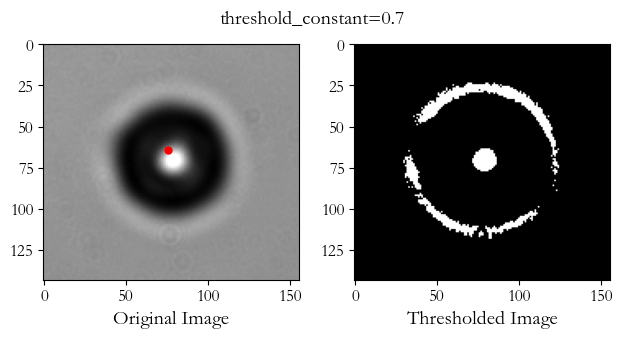

In [18]:
from turtle import title


plt.subplot(1,2,1)
plt.imshow(roi1_array,cmap='gray')
plt.title('Original Image', y=-0.3, pad=20)  # 新增：标题在图片下方
# 计算并标记质心
from skimage.measure import regionprops
props = regionprops(roi1_binary.astype(int))
for prop in props:
    y, x = prop.centroid
    plt.plot(x, y, 'ro', markersize=5)  # 红色圆点标记质心

plt.subplot(1,2,2)
plt.imshow(roi1_binary,cmap='gray')
plt.title('Thresholded Image', y=-0.3, pad=20)  # 新增：标题在图片下方
plt.suptitle(f'threshold_constant={threshold_constant}',y=0.78)
plt.tight_layout()
plt.show()